# Numerical Simulation Methods in Python

A brief, practical introduction to numerical integration schemes in Python for scientific simulations.

First, let's define the minimum toolset we require: 

In [2]:
import numpy as np  # Numeric Python
import matplotlib.pyplot as plt  # Plotting Library
import time  # Timing for performance profiling
import pandas as pd  # Visual representation of structured data
from typing import Dict, Callable, Tuple  # Types for type-hinting
from functools import partial  # Pre-assign parameters of functions

## Time Integration

The following methods will be defined by a select few number of naming conventions, that are:
- $t$ time value
- $dt$ stepsize to the next point in time
- $y(t)$ the state at time $t$
- $dy(t)/dt = y'(t) = f(y, t)$ the gradient at time $t$  for state $y(t)$

Note that $y$ can be any number of fields, therefore for implementation purposes we will portray this as a dictionary where each field will be explicitly named. Due to the Hashtable implementation of Python dictionaries, there is no penalty to flexibility on field dimensions at O(1) computational cost to solve the biggest issue in implementing numerical methods: mixing up elements. 

### Test Method: 

#### Pendulum with gravity and friction

To test the integration schemes to follow, we will need a function that varies. Ideally it has more than field to show how these methdos can generalize over these more useful methods than trivial one field methods.

Luckily the [SciPy Example](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) provides such an example that is also illustrated across the SciPy methods in [this tutorial extensively](https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html):

$$
\theta''(t) + b\, \theta'(t) + c\, \mathrm{sin}\left(\theta\left(t\right)\right) = 0
$$
that can be rewritten using $\omega(t)=\theta'(t)$:
$$
\begin{align}
\theta'(t) &= \omega(t)  \\
\omega'(t) &= -b\, \omega(t) - c\, \mathrm{sin}\left(\theta\left(t\right)\right)
\end{align}
$$

Packing the state of the fields $\theta$ and $\omega$ into a dictionary allows for clear description of the gradient at time $t$:

In [3]:
def pend(state: Dict[str, np.ndarray], b: float, c: float, t: float | None = None) -> Dict[str, np.ndarray]:
    theta = state["theta"]
    omega = state["omega"]
    d_theta = omega
    d_omega = - b * omega - c * np.sin(theta)
    return {"theta": d_theta, "omega": d_omega}

#### Attractor Models

##### Lorenz attractor

In [4]:
def lorenz_attractor(state: Dict[str, float], t: float | None = None, sigma: float = 10, rho: float = 28, beta: float = 8 / 3):
    dx = sigma * (state["y"] - state["x"])
    dy = state["x"] * (rho - state["z"]) - state["y"]
    dz = state["x"] * state["y"] - beta * state["z"]
    return {"x": dx, "y": dy, "z": dz}

##### [Rössler attractor](https://en.wikipedia.org/wiki/R%C3%B6ssler_attractor)

In [5]:
# original:  a: float = 0.2, b: float = 0.2, c: float = 5.7
# more common:  a: float = 0.1, b: float = 0.1, c: float = 14
def roessler_attractor(state: Dict[str, float], t: float | None = None, a: float = 0.1, b: float = 0.1, c: float = 14):
    dx = - state["y"] - state["z"]
    dy = state["x"] + a * state["y"]
    dz = b + state["z"] * (state["x"] - c)
    return {"x": dx, "y": dy, "z": dz}

##### [Thomas' cyclically symmetric attractor](https://en.wikipedia.org/wiki/Thomas%27_cyclically_symmetric_attractor)

In [ ]:
def thomas_attractor(state: Dict[str, float], b: float = 1):
    dx = np.sin(state["y"]) - b * state["x"]
    dy = np.sin(state["z"]) - b * state["y"]
    dz = np.sin(state["x"]) - b * state["z"]
    return {"x": dx, "y": dy, "z": dz}

##### [Lorenz 96 Model](https://en.wikipedia.org/wiki/Lorenz_96_model)

In [ ]:
def L96(x: np.ndarray, t: float | None = None, N: int=5, F: float=8):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

#### [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)

In [ ]:
def lotka_volterra(state: Dict[str, float], alpha: float, beta: float, delta: float, gamma: float):
    """
    x: population density of prey
    y: population density of predator
    alpha: maximum prey per capita
    beta: effect of the presence of predators on the prey growth
    gamma: predators per capita death rate
    delta: effect of the presence of prey on the predators growth rate
    All parameters are positive and real
    """
    # Instantaneous growth rates
    dx = alpha * state["x"] - beta * state["x"] * state["y"]
    dy = delta * state["x"] * state["y"] - gamma * state["y"]
    return {"x": dx, "y": dy}

### Setting up integration method code

#### Introduction

The following will focus on explicit single-step integration schemes. These will produce the next discrete state of the numerical approximation to the function based:
- `state` the current state
- `gradient_func` function returning the gradient
- `t` the current time
- `dt` the discrete step in time

In the following we will refer to all intermediary gradients by `k` that will uniformize the presentation for the Runge-Kutta methods later on. 
Specifically, `k1` is the gradient at the current state, which might be calculated before and is hence optionally already passed as a parameter.

The primary value of interest that will be returned is the new state. Since we are doing a discrete approximation of the true value at this point in time, it often is of interest to get an error approximation done. These might involve the gradient at the final point, which can be returned additionally to prevent recomputing in the next iteration. 

Based on these consideration the functions should return 3 distinct values:
- `new_states` the state at the new time
- `new_grad` the gradient at the new state (if available, else None)
- `errors` the errors of each field based on the timestep (if available, else None)

| Analytic                            | Description         | Name                        | Type                  |
| ----------------------------------- | ------------------- | --------------------------- | --------------------- |
| $t$                                 | time variable       | `t`                         | float                 |
| $dt$                                | time discretization | `dt`                        | float                 |
| $y(t)$                              | state of fields     | `states` and `new_states`   | Dict[str, np.ndarray] |
| $\frac{d}{dt}\, (y) = \partial_t$   | gradient function   | `gradient_func`             | Callable              |
| $dy(t)/dt = y'(t) = f(y, t)$        | gradient of fields  | `gradient`, `k1`, `k2`, ... | Dict[str, np.ndarray] |


The result from these considerations is a framework for the function like:

```python
def step_function(
    dt: float, 
    gradient_func: Callable,
    states: Dict[str, np.ndarray],
    k1: None or Dict[str, np.ndarray]=None,
    **kwargs
) -> Tuple[
    Dict[str, np.ndarray] or None, 
    Dict[str, np.ndarray] or None, 
    Dict[str, np.ndarray] or None
]:
    new_states, new_grad, errors = None
    # ... calculate the new steps ...
    return new_states, new_grad, errors
```

### [Runge-Kutta Methods](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods)

#### RK1 aka the (Forward) Euler Method

The simplest way to integrate is the Euler integration scheme. Timestep $y(t+1)$ is given by the state $y(t)$ propoated by the gradient $f(y, t)$ for a timeframe $dt$: 
$$\quad y(t+1) = y(t) + dt \times f(y, t)$$

For more resources on the Euler integration scheme:
- [Wikipedia](https://en.wikipedia.org/wiki/Euler_method)
- [Python Numerical Methods](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter22.03-The-Euler-Method.html)

In [6]:
def euler_step(
    dt: float, 
    gradient_func: Callable, 
    states: Dict[str, np.ndarray], 
    k1: Dict[str, np.ndarray] or None=None, 
    **kwargs
) -> Tuple[Dict[str, np.ndarray], None, None]:
    if k1 is None:
        k1 = gradient_func(states)
    new_states = {field: states[field] + dt * k1[field] for field in states.keys()}
    errors = None
    new_grad = None
    return new_states, new_grad, errors

#### [RK2 Methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Second-order_methods_with_two_stages)

$$
y(t+1) = y(t) + h \left( 1 - \frac{1}{2\alpha} f(y, t) + \frac{1}{2\alpha} f\left( y + dt\; \alpha\; f(y, t), t \right) \right) 
$$

##### Midpoint Method $\left(\alpha = \frac{1}{2}\right)$

In [7]:
def midpoint_step(
    dt: float, 
    gradient_func: Callable, 
    states: Dict[str, np.ndarray], 
    t: float, 
    k1: Dict[str, np.ndarray]=None, 
    **kwargs
) -> Tuple[Dict[str, np.ndarray], None, None]:
    # RK2 Predictor-Corector step
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({key: states[key] + h * k1[key] for key in states.keys()}, t=t + h / 2, **kwargs)
    yk1 = {
        key: states[key] + (h / 2.) * (k1[key] + k2[key]) 
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return yk1, new_grad, errors

##### General Implementation

In [8]:
def rk2_step(
    dt: float, 
    gradient_func: Callable, 
    states: Dict[str, np.ndarray], 
    t: float, 
    alpha: float,
    k1: Dict[str, np.ndarray]=None, 
    tol: float = 0,
    **kwargs
) -> Tuple[Dict[str, np.ndarray], None, None]:
    # RK2 Predictor-Corector step
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func(
        {key: states[key] + h * alpha * k1[key] for key in states.keys()}, 
        t=t + alpha*h, 
        **kwargs
    )
    yk1 = {
        key: states[key] + h * (
            (1-1/(2*alpha)) * k1[key] 
            + 1/(2*alpha) * (k2[key]) 
        )
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return yk1, new_grad, errors

This means we can use partial parameter assignment to generate the midpoint and other methods from the `rk2_step()` function.

In [9]:
def midpoint_step(*args, **kwargs):
    return rk2_step(*args, alpha=1/2, **kwargs)

def heun_step(*args, **kwargs):
    return rk2_step(*args, alpha=1, **kwargs)

def ralston_step(*args, **kwargs):
    return rk2_step(*args, alpha=2/3, **kwargs)

Heun's Method and Ralson's Method ....

In [10]:
second_order_methods = (midpoint_step, heun_step, ralston_step)

### [RK3 Methods](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Kutta's_third-order_method)

In [11]:
def kutta3_step(dt: float, gradient_func: Callable, states: Dict[str, np.ndarray], t: float, tol: float or False=False, k1=None, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({key: states[key] + k1[key] * h / 2. for key in states.keys()}, t=t + h / 2., **kwargs)
    k3 = gradient_func({key: states[key] + k1[key] * h      for key in states.keys()}, t=t + h, **kwargs)
    new_states = {
        key: states[key] + (h / 6.) * (k1[key] + 4*k2[key] + k3[key]) 
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

##### [Generic 3rd order method](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Generic_third-order_method)

In [12]:
def rk3_step(dt, gradient_func, states, t, alpha, k1=None, tol=False, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({
            key: states[key] + h * alpha * k1[key] 
            for key in states.keys()}, 
        t=t + h * alpha, **kwargs)
    k3 = gradient_func({
            key: states[key] + h * (
                (1 + (1-alpha)/(alpha*(3*alpha - 2))) * k1[key] 
                   - (1-alpha)/(alpha * (3*alpha -2)) * k2[key]
            )
            for key in states.keys()}, 
        t=t + h, **kwargs)
    new_states = {
        key: states[key] + h * ( 
            (1/2 - 1 / (6 * alpha) ) * k1[key] 
            + (1 / (6 * alpha * (1 - alpha))) * k2[key] 
            + (2 - 3 * alpha) / (6 * (1 - alpha)) * k3[key]
        ) 
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

##### [Other 3rd order method](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Generic_third-order_method)

In [13]:
def heun3_step(dt, gradient_func, states, t, k1=None, tol=False, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({key: states[key] + h / 3 * k1[key]     for key in states.keys()}, t=t + h / 3, **kwargs)
    k3 = gradient_func({key: states[key] + h * 2 / 3 * k2[key] for key in states.keys()}, t=t + h * 2 / 3, **kwargs)
    new_states = {
        key: states[key] + h * (k1[key] + 3 * k3[key]) / 4
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

In [14]:
def vdhw3_step(dt, gradient_func, states, t, k1=None, tol=False, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({
        key: states[key] + h * k1[key]  * 8 / 15                
        for key in states.keys()}, t=t + h * 8 / 15, **kwargs)
    k3 = gradient_func({
        key: states[key] + h * (k1[key] / 4 + k2[key] * 5 / 12) 
        for key in states.keys()}, t=t + h * 2 / 3, **kwargs)
    new_states = {
        key: states[key] + h * ( 
            k1[key] / 4
            + k3[key] * 3 / 4
        ) 
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

In [15]:
def ssprk3_step(dt, gradient_func, states, t, k1=None, tol=False, **kwargs):
    """Third-order Strong Stability Preserving Runge-Kutta (SSPRK3)"""
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({
        key: states[key] + h * k1[key]                 for key in states.keys()}, 
        t=t + h, **kwargs)
    k3 = gradient_func({
        key: states[key] + h * (k1[key] + k2[key]) / 4 for key in states.keys()}, 
        t=t + h / 2, **kwargs)
    new_states = {
        key: states[key] + h * (k1[key] + k2[key] + k3[key] * 4) / 6
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

In [16]:
def raltons3_step(dt, gradient_func, states, t, k1=None, tol=False, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({
            key: states[key] + h / 2 * k1[key] 
            for key in states.keys()}, 
        t=t + h / 2, **kwargs)
    k3 = gradient_func({
            key: states[key] + h * (
                   k2[key] * 3 / 4
            )
            for key in states.keys()}, 
        t=t + h * 3 / 4, **kwargs)
    new_states = {
        key: states[key] + h * ( 
            (2 / 9) * k1[key] 
            + (1 / 3) * k2[key] 
            + (4 / 9) * k3[key]
        ) 
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

In [17]:
def rk38_step(dt, gradient_func, states, t, tol=False, k1=None, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({key: states[key] + h * (k1[key] / 3.) for key in states.keys()}, t=t + h / 3., **kwargs)
    k3 = gradient_func({key: states[key] + h * (- k1[key] / 3. + k2[key]) for key in states.keys()}, t=t + 2 * h / 3., **kwargs)
    k4 = gradient_func({key: states[key] + h * (k1[key] - k2[key] + k3[key])  for key in states.keys()}, t=t + h, **kwargs)
    new_states = {
        key: states[key] + (h / 8.) * (k1[key] + 3*k2[key] + 3*k3[key] + k4[key]) 
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

In [21]:
def rkbs_step(dt, gradient_func, states, t, tol=False, k1=None, **kwargs):
    # "3" stages (4th shared among iterations)
    # First Same As Last (FSAL)
    # https://en.wikipedia.org/wiki/Bogacki%E2%80%93Shampine_method
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    y1 = {
        key: states[key] + h * k1[key] / 2. 
        for key in states.keys()
    }
    k2 = gradient_func(y1, t=t + h / 2., **kwargs)
    y2 = {
        key: states[key] + h * (k2[key] * (3 / 4))
        for key in states.keys()
    }
    k3 = gradient_func(y2, t=t + h * 3 / 4, **kwargs)
    yk1 = {
        key: states[key] + h * (k1[key] * (2 / 9) + k2[key] * (1 / 3) + k3[key] * (4 / 9))  
        for key in states.keys()
    }
    errors = {field: 0 for field in yk1.keys()}
    new_grad = None
    if tol:
        new_grad = gradient_func(yk1, t=t + h, **kwargs)
        k4 = new_grad
        zk1 = {
            key: states[key] + h * (
                k1[key] * (7 / 24)
                + k2[key] * (1 / 4)
                + k3[key] * (1 / 3)
                + k4[key] * (1 / 8)
            )
            for key in states.keys()
        }
        # Error estimation
        errors = {k: yk1[k] - zk1[k] for k in yk1.keys()}
    return yk1, new_grad, errors

In [22]:
third_order_methods = (kutta3_step, heun3_step, vdhw3_step, ssprk3_step, raltons3_step, rkbs_step, rk38_step)

### RK4 Methods

In [19]:
def rk4_step(dt, gradient_func, states, t, tol=False, k1=None, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    k2 = gradient_func({key: states[key] + k1[key] * h / 2. for key in states.keys()}, t=t + h / 2., **kwargs)
    k3 = gradient_func({key: states[key] + k2[key] * h / 2. for key in states.keys()}, t=t + h / 2., **kwargs)
    k4 = gradient_func({key: states[key] + k3[key] * h  for key in states.keys()}, t=t + h, **kwargs)
    new_states = {
        key: states[key] + (h / 6.) * (k1[key] + 2*k2[key] + 2*k3[key] + k4[key]) 
        for key in states.keys()
    }
    errors = None
    new_grad = None
    return new_states, new_grad, errors

In [23]:
def rkdp_step(dt, gradient_func, states, t, tol=False, k1=None, **kwargs):
    # 5th order accurate 
    # 6 evaluations (7th is shared - First Same As Last)
    # https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    y1 = {
        key: states[key] + k1[key] * h / 5. 
        for key in states.keys()
    }
    k2 = gradient_func(y1, t=t + h / 5., **kwargs)
    y2 = {
        key: states[key] + h * (k1[key] * (3 / 40) + k2[key] * (9 / 40))
        for key in states.keys()
    }
    k3 = gradient_func(y2, t=t + h * 3 / 10, **kwargs)
    y3 = {
        key: states[key] + h * (k1[key] * (44 / 45) - k2[key] * (56 / 15) + k3[key] * (32 / 9))  
        for key in states.keys()
    }
    k4 = gradient_func(y3, t=t + h * 4 / 5, **kwargs)
    y4 = {
        key: states[key] + h * (
              k1[key] * (19_372 / 6_561)
            - k2[key] * (25_360 / 2_187)
            + k3[key] * (64_448 / 6_561)
            - k4[key] * (212 / 729)
        ) 
        for key in states.keys()
    }
    k5 = gradient_func(y4, t=t + h * 8 / 9, **kwargs)
    y5 = {
        key: states[key] + h * (
              k1[key] * (9_017 / 3_186)
            - k2[key] * (355 / 33)
            + k3[key] * (46_732 / 5_247)
            + k4[key] * (49 / 176)
            - k5[key] * (5_103 / 18_656)
        )
        for key in states.keys()
    }
    k6 = gradient_func(y5, t=t + h, **kwargs)
    yk1 = {
        key: states[key] + h * (
              k1[key] * (35 / 384)
            + k3[key] * (500 / 1_113)
            + k4[key] * (125 / 192)
            - k5[key] * (2_187 / 6_784)
            + k6[key] * (11 / 84)
        )
        for key in states.keys()
    }
    errors = None
    new_grad = None
    if tol:
        new_grad = gradient_func(yk1, t=t + h, **kwargs)
        k7 = new_grad
        zk1 = {
            key: states[key] + h * (
                k1[key] * (5_179 / 57_600)
                + k3[key] * (7_571 / 16_695)
                + k4[key] * (393 / 640)
                - k5[key] * (92_097 / 339_200)
                + k6[key] * (187 / 2_100)
                + k7[key] * (1 / 40) 
            )
            for key in states.keys()
        }
        # Error estimation
        errors = {k: yk1[k] - zk1[k] for k in yk1.keys()}
    return yk1, new_grad, errors

In [24]:
def rkck_step(dt, gradient_func, states, t, tol=False, k1=None, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    y1 = {
        key: states[key] + k1[key] * h / 5. 
        for key in states.keys()
    }
    k2 = gradient_func(y1, t=t + h / 5., **kwargs)
    y2 = {
        key: states[key] + h * (k1[key] * (3 / 40) + k2[key] * (9 / 40))
        for key in states.keys()
    }
    k3 = gradient_func(y2, t=t + h * 3 / 10, **kwargs)
    y3 = {
        key: states[key] + h * (k1[key] * (3 / 10) - k2[key] * (9 / 10) + k3[key] * (6 / 5))  
        for key in states.keys()
    }
    k4 = gradient_func(y3, t=t + h * 3 / 5, **kwargs)
    y4 = {
        key: states[key] + h * (
            - k1[key] * (3 / 10)
            + k2[key] * (5 / 2)
            - k3[key] * (70 / 27)
            + k4[key] * (35 / 27)
        )
        for key in states.keys()
    }
    k5 = gradient_func(y4, t=t + h * 1, **kwargs)
    y5 = {
        key: states[key] + h * (
              k1[key] * (1_631 / 55_296)
            + k2[key] * (175 / 412)
            + k3[key] * (575 / 13_824)
            + k4[key] * (44_275 / 110_592)
            + k5[key] * (253 / 4_096)
        )
        for key in states.keys()
    }
    k6 = gradient_func(y5, t=t + h * 7 / 8, **kwargs)
    new_states = {
        key: states[key] + h * (
              k1[key] * (37 / 378)
            + k3[key] * (250 / 621)
            + k4[key] * (125 / 594)
            + k6[key] * (512 / 1_771)
        )
        for key in states.keys()
    }
    errors = None
    new_grad = None
    # Error estimate
    if tol:
        lesser_estimate = {
            key: states[key] + h * (
                k1[key] * (2_825 / 27_648)
                + k3[key] * (18_575 / 48_384)
                + k4[key] * (13_525 / 55_296)
                + k5[key] * (277 / 14_336)
                + k6[key] * (1 / 4)
            )
            for key in states.keys()
        }
        errors = {key: new_states[key] - lesser_estimate[key] for key in new_states.keys()}
    return new_states, new_grad, errors

In [25]:
def rkf45_step(dt, gradient_func, states, t, tol=0.1, k1=None, **kwargs):
    h = dt
    if k1 is None:
        k1 = gradient_func(states, t=t, **kwargs)
    y1 = {
        key: states[key] + k1[key] * h / 4. 
        for key in states.keys()
    }
    k2 = gradient_func(y1, t=t + h / 4., **kwargs)
    y2 = {
        key: states[key] + h * (k1[key] * (3 / 32) + k2[key] * (9 / 32))
        for key in states.keys()
    }
    k3 = gradient_func(y2, t=t + h * 3 / 8, **kwargs)
    y3 = {
        key: states[key] + h * (
            k1[key] * (1_932 / 2_197) 
            - k2[key] * (7_200 / 2_197) 
            + k3[key] * (7_296 / 2_197)
        )  
        for key in states.keys()
    }
    k4 = gradient_func(y3, t=t + h * 12 / 13, **kwargs)
    y4 = {
        key: states[key] + h * (
            k1[key] * (439 / 216)
            - k2[key] * (8)
            + k3[key] * (3_680 / 513)
            - k4[key] * (845 / 4_104)
        ) 
        for key in states.keys()
    }
    k5 = gradient_func(y4, t=t + h, **kwargs)
    y5 = {
        key: states[key] + h * (
            - k1[key] * (8 / 27)
            + k2[key] * (2)
            - k3[key] * (3_544 / 2_565)
            + k4[key] * (1_859 / 4_104)
            - k5[key] * (11 / 40)
        )
        for key in states.keys()
    }
    k6 = gradient_func(y5, t=t + h / 2, **kwargs)
    zk1 = {
        key: states[key] + h * (
            k1[key] * (16 / 135)
            + k3[key] * (6_656 / 12_825)
            + k4[key] * (28_561 / 56_430)
            - k5[key] * (9 / 50)
            + k6[key] * (2 / 55)
        )
        for key in states.keys()
    }
    errors = None
    new_grad = None
    if tol:
        yk1 = {
            key: states[key] + h * (
                k1[key] * (25 / 216)
                + k3[key] * (1_408 / 2_565)
                + k4[key] * (2_197 / 4_101)
                - k5[key] * (1 / 5)
            )
            for key in states.keys()
        }
        # Error estimation
        errors = {k: zk1[k] - yk1[k] for k in zk1.keys()}
    return zk1, new_grad, errors

In [26]:
fourth_order_methods = (rk4_step, rkbs_step, rkdp_step, rkck_step, rkf45_step)

In [27]:
integration_methods = (
    # First-order methods
    euler_step, 
    # Second-order methods
    midpoint_step, heun_step, ralston_step, 
    # Third-order methods
    kutta3_step, heun3_step, vdhw3_step, ssprk3_step, raltons3_step, rkbs_step, rk38_step, 
    # Fourth-order methods
    rk4_step, rkbs_step, rkdp_step, rkck_step, rkf45_step,
)

In [30]:
len([euler_step, *second_order_methods, *third_order_methods, *fourth_order_methods])

16

In [63]:
adaptive_methods = (rkbs_step, rkdp_step, rkck_step, rkf45_step)

### Adaptive Timestepping Wrapper

In [90]:
def adaptive_timestep(integration_func, gradient_func, dt, states, t, tol, max_increase:float|None = 2,**kwargs):
    converged = False
    rejected = []
    k1 = None
    while True:
        # Step
        states, k1, errors = integration_func(dt, gradient_func, states, t=t, tol=tol, k1=k1, **kwargs)
        if errors is None:
            converged = True
            next_dt = dt
        elif not tol:
            converged = True
            next_dt = dt
        elif tol:
            # Check
            abs_error_norm = {k: np.mean(np.abs(errors[k])) for k in errors.keys()}
            #rel_error_norm = {k: np.mean(np.abs(errors[k] / states[k])) for k in errors.keys()}
            max_error = {
                k: tol * (1 + np.mean(np.abs(states[k]))) for k in states.keys()
            }  # relative/absolute blend

            # s_T = np.sqrt(np.sqrt(tol * dt / (2 * np.sum(np.abs(zk1["T"] - yk1["T"])))))
            # s = np.sqrt(np.sqrt(tol * dt / (2 * np.sum(np.abs(zk1 - yk1)))))

            # Adjust step size
            adjustment = {
                #k: np.sqrt(np.sqrt(max_error[k] / abs_error_norm[k]))
                k: np.sqrt(np.sqrt(tol / (2 * np.sum(np.abs(errors[k])))))
                for k in max_error.keys()
            }

            # Bias to smaller step size
            next_dt = np.min([dt * val for val in adjustment.values()]) * 0.98
            if max_increase is not None:
                next_dt = np.min([next_dt,max_increase*dt])
            if all([abs_error_norm[k] < max_error[k] for k in abs_error_norm.keys()]):
                converged = True
            else:
                rejected.append(dt)
                #print(f"abs_error_norm:  {abs_error_norm}")
                #print(f"rel_error_norm:  {rel_error_norm}")
                #print(f"max_error:       {max_error}")
                #print(f"adjustment:      {adjustment}")
                #print(f"unacceptable | {dt:.4g} -> {next_dt:.4g}")
                dt = next_dt * 0.98
        if converged:
            #if rejected:
            #    rejected = [f"{i:.2g}" for i in rejected]
            #    print(f"rejected: {rejected}")
            #else:
            #    print(dt, next_dt)
            return next_dt, dt, states

### Integration Wrapper

Run the integration from an initial state to a final state

In [23]:
def run_integration(step_func, gradient_func, states, t_now, t_end, dt, tol, **kwargs):
    # History of fields and time
    history = {
        "t": [t_now],
        **{k: [val] for k, val in states.items()}
    }
    while t_now < t_end - dt:
        dt, dt_used, states = adaptive_timestep(
            integration_func=step_func, 
            dt=dt, 
            gradient_func=gradient_func, 
            states=states, 
            tol=tol, 
            t=t_now, 
            **kwargs
        )
        t_now += dt_used
        history["t"].append(t_now)
        for k in states.keys():
            history[k].append(states[k])
    return history

### Examples

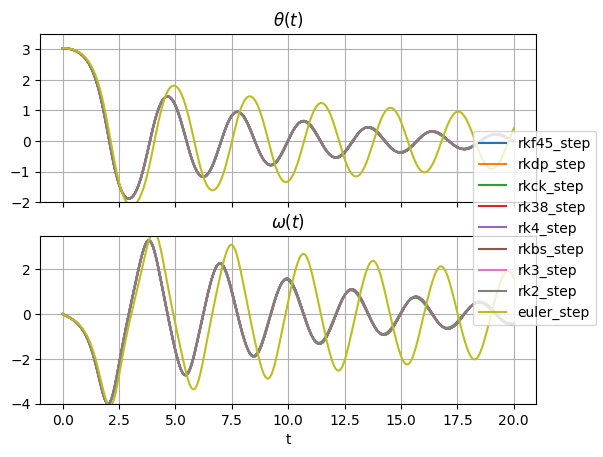

,times,length
euler_step,0.001509,501
rk2_step,0.003577,501
rk3_step,0.004838,501
rk4_step,0.005917,501
rk38_step,0.006813,501
rkdp_step,0.016057,157
rkbs_step,0.022133,328
rkf45_step,0.034347,397
rkck_step,0.034628,428


In [449]:
# Define Function & Parameters
f = pend
b = 0.25
c = 5.0
# Time to integrate
t_end = 20
t_now = 0
dt = 0.04
tol = 0.0001
# Initial State
theta = np.pi - 0.1
omega = 0.0
# Run simulation
states = {"theta": theta, "omega": omega}
times = {}
histories = {}
length = {}
#for fnc in (euler_step, rk3_step, rkbs_step, rk4_step, rk38_step, rkck_step, rkdp_step, rkf45_step):
for fnc in (euler_step, rk2_step, rk3_step, rkbs_step, rk4_step, rk38_step, rkck_step, rkdp_step, rkf45_step)[::-1]:
    t0 = time.time()
    name = fnc.__name__
    histories[name] = run_integration(step_func=fnc, gradient_func=f, states=states, t_now=t_now, t_end=t_end, dt=dt, tol=tol)
    times[name] = time.time() - t0
    length[name] = len(histories[name]["theta"])
fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].set_title(r'$\theta(t)$')
axarr[1].set_title(r'$\omega(t)$')
for fnc_name, hist in histories.items():
    axarr[0].plot(hist["t"], hist["theta"], label=fnc_name)
    axarr[1].plot(hist["t"], hist["omega"])
fig.legend(loc="center right")
#axarr[0].set_xlabel('t')
axarr[0].grid()
axarr[0].set_ylim(-2, 3.5)
#axarr[1].legend(loc='best')
axarr[1].set_xlabel('t')
axarr[1].grid()
axarr[1].set_ylim(-4, 3.5)
plt.show()
pd.DataFrame(dict(times=times, length=length)).sort_values("times")

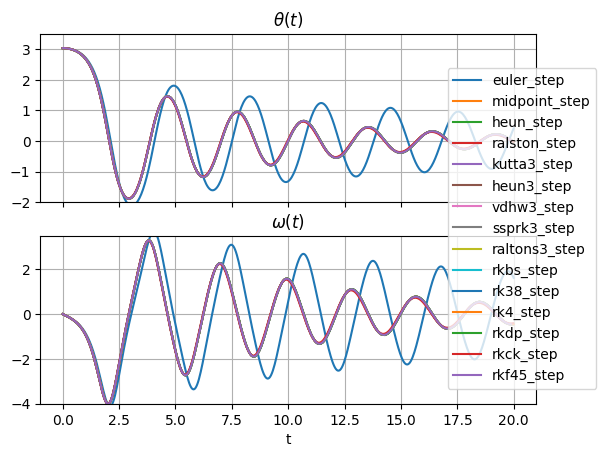

,times,length
euler_step,0.001997,501
midpoint_step,0.002998,501
heun_step,0.002999,501
ralston_step,0.003002,501
raltons3_step,0.004004,501
ssprk3_step,0.004007,501
heun3_step,0.004023,501
kutta3_step,0.004507,501
vdhw3_step,0.004670,501
rk4_step,0.005002,501


In [86]:
# Define Function & Parameters
b = 0.25
c = 5.0
f = partial(pend, b=b, c=c)
# Time to integrate
t_end = 20
t_now = 0
dt = 0.04
tol = 0.0001
# Initial State
theta = np.pi - 0.1
omega = 0.0
# Run simulation
states = {"theta": theta, "omega": omega}
times = {}
histories = {}
length = {}
for fnc in integration_methods:
    t0 = time.time()
    name = fnc.__name__
    histories[name] = run_integration(
        step_func=fnc, 
        gradient_func=f, 
        states=states, 
        t_now=t_now, 
        t_end=t_end, 
        dt=dt, 
        tol=tol
    )
    times[name] = time.time() - t0
    length[name] = len(histories[name]["theta"])
fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].set_title(r'$\theta(t)$')
axarr[1].set_title(r'$\omega(t)$')
for fnc_name, hist in histories.items():
    axarr[0].plot(hist["t"], hist["theta"], label=fnc_name)
    axarr[1].plot(hist["t"], hist["omega"])
fig.legend(loc="center right")
#axarr[0].set_xlabel('t')
axarr[0].grid()
axarr[0].set_ylim(-2, 3.5)
#axarr[1].legend(loc='best')
axarr[1].set_xlabel('t')
axarr[1].grid()
axarr[1].set_ylim(-4, 3.5)
plt.show()
pd.DataFrame(dict(times=times, length=length)).sort_values("times")

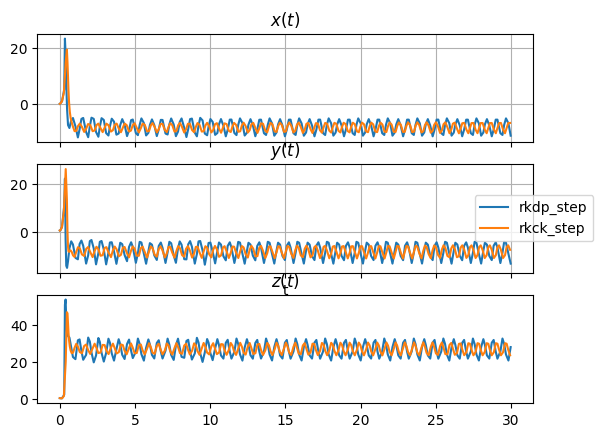

,times,length
rkdp_step,0.021493,220
rkck_step,0.022468,244


In [91]:
# Define Function & Parameters
f = lorenz_attractor
# Time to integrate
t_end = 30
t_now = 0
dt = 0.05
tol = 0.05
# Initial State
states = {"x": np.random.rand(), "y": np.random.rand(), "z":np.random.rand()}
# Run simulation
times = {}
histories = {}
length = {}
#for fnc in (euler_step, rk3_step, rkbs_step, rk4_step, rk38_step, rkck_step, rkdp_step, rkf45_step):
for fnc in (rkdp_step, rkck_step):#adaptive_methods:
    t0 = time.time()
    name = fnc.__name__
    histories[name] = run_integration(step_func=fnc, gradient_func=f, states=states, t_now=t_now, t_end=t_end, dt=dt, tol=tol)
    times[name] = time.time() - t0
    length[name] = len(histories[name]["x"])
fig, axarr = plt.subplots(3, 1, sharex=True)
axarr[0].set_title(r'$x(t)$')
axarr[1].set_title(r'$y(t)$')
axarr[2].set_title(r'$z(t)$')
for fnc_name, hist in histories.items():
    axarr[0].plot(hist["t"], hist["x"], label=fnc_name)
    axarr[1].plot(hist["t"], hist["y"])
    axarr[2].plot(hist["t"], hist["z"])
fig.legend(loc="center right")
#axarr[0].set_xlabel('t')
axarr[0].grid()
#axarr[0].set_ylim(-2, 3.5)
#axarr[1].legend(loc='best')
axarr[1].set_xlabel('t')
axarr[1].grid()
##axarr[1].set_ylim(-4, 3.5)
plt.show()
pd.DataFrame(dict(times=times, length=length)).sort_values("times")

C:\Users\robin\AppData\Local\Temp\ipykernel_9588\1771558045.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  k: np.sqrt(np.sqrt(tol / (2 * np.sum(np.abs(errors[k])))))


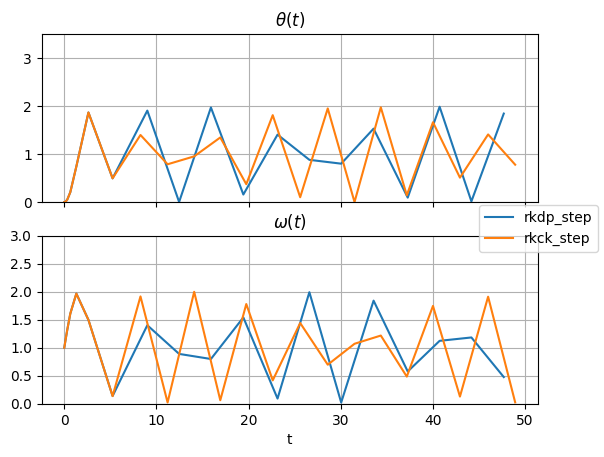

,times,length
rkdp_step,0.002512,32
rkck_step,0.002999,35


In [95]:
def f(state, t):
    sin = state["sin"]
    cos = state["cos"]
    return {"sin": np.sin(t), "cos": np.cos(t)}
# Define Function & Parameters
b = 0.25
c = 5.0
# Time to integrate
t_end = 50
t_now = 0
dt = 0.00001
tol = 0.01
# Initial State
theta = np.sin(0.0)
omega = np.cos(0.0)
# Setup
states = {"sin": theta, "cos": omega}
times = {}
histories = {}
length = {}
# Run Comparison Simulations
for fnc in (rkdp_step, rkck_step):#adaptive_methods:
    t0 = time.time()
    name = fnc.__name__
    histories[name] = run_integration(step_func=fnc, gradient_func=f, states=states, t_now=t_now, t_end=t_end, dt=dt, tol=tol)
    times[name] = time.time() - t0
    length[name] = len(histories[name]["sin"])
# Plotting
fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].set_title(r'$\theta(t)$')
axarr[1].set_title(r'$\omega(t)$')
for fnc_name, hist in histories.items():
    axarr[0].plot(hist["t"], hist["sin"], label=fnc_name)
    axarr[1].plot(hist["t"], hist["cos"])
fig.legend(loc="center right")
axarr[0].grid()
axarr[0].set_ylim(0, 3.5)
axarr[1].set_xlabel('t')
axarr[1].grid()
axarr[1].set_ylim(0, 3)
# Summary
plt.show()
pd.DataFrame(dict(times=times, length=length)).sort_values("times")

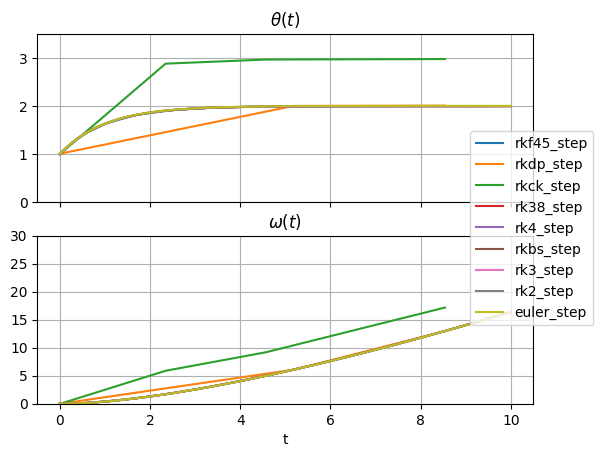

,times,length
rkdp_step,0.000000,4
rkbs_step,0.001000,18
rkf45_step,0.001001,19
rkck_step,0.001003,5
euler_step,0.004573,1001
rk2_step,0.007000,1001
rk3_step,0.010513,1001
rk4_step,0.014102,1001
rk38_step,0.018954,1001


In [474]:
f = lambda state, t: {"exp": np.exp(-t), "log": np.log(t+1)} # ODE
# Define Function & Parameters
b = 0.25
c = 5.0
# Time to integrate
t_end = 10
t_now = 0
dt = 0.01
tol = 0.001
# Setup
states = f({},t_now)
times = {}
histories = {}
length = {}
# Run Comparison Simulations
for fnc in (euler_step, rk2_step, rk3_step, rkbs_step, rk4_step, rk38_step, rkck_step, rkdp_step, rkf45_step)[::-1]:
    t0 = time.time()
    name = fnc.__name__
    histories[name] = run_integration(step_func=fnc, gradient_func=f, states=states, t_now=t_now, t_end=t_end, dt=dt, tol=tol)
    times[name] = time.time() - t0
    length[name] = len(histories[name]["exp"])
# Plotting
fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].set_title(r'$\theta(t)$')
axarr[1].set_title(r'$\omega(t)$')
for fnc_name, hist in histories.items():
    axarr[0].plot(hist["t"], hist["exp"], label=fnc_name)
    axarr[1].plot(hist["t"], hist["log"])
fig.legend(loc="center right")
axarr[0].grid()
axarr[0].set_ylim(0, 3.5)
axarr[1].set_xlabel('t')
axarr[1].grid()
axarr[1].set_ylim(0, 30)
# Summary
plt.show()
pd.DataFrame(dict(times=times, length=length)).sort_values("times")

In [ ]:
f = lambda state, t: {"exp": np.exp(-t), "log": np.log(t+1)} # ODE
# Define Function & Parameters
b = 0.25
c = 5.0
# Time to integrate
t_end = 10
t_now = 0
dt = 0.01
tol = 0.001
# Setup
states = f({},t_now)
times = {}
histories = {}
length = {}
# Run Comparison Simulations
for fnc in (euler_step, rk2_step, rk3_step, rkbs_step, rk4_step, rk38_step, rkck_step, rkdp_step, rkf45_step)[::-1]:
    t0 = time.time()
    name = fnc.__name__
    histories[name] = run_integration(step_func=fnc, gradient_func=f, states=states, t_now=t_now, t_end=t_end, dt=dt, tol=tol)
    times[name] = time.time() - t0
    length[name] = len(histories[name]["exp"])
# Plotting
fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].set_title(r'$\theta(t)$')
axarr[1].set_title(r'$\omega(t)$')
for fnc_name, hist in histories.items():
    axarr[0].plot(hist["t"], hist["exp"], label=fnc_name)
    axarr[1].plot(hist["t"], hist["log"])
fig.legend(loc="center right")
axarr[0].grid()
axarr[0].set_ylim(0, 3.5)
axarr[1].set_xlabel('t')
axarr[1].grid()
axarr[1].set_ylim(0, 30)
# Summary
plt.show()
pd.DataFrame(dict(times=times, length=length)).sort_values("times")

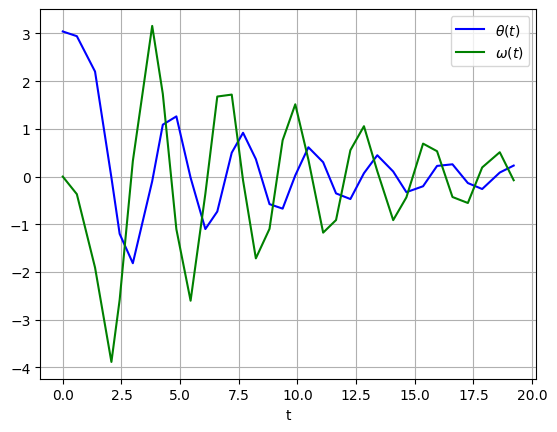

In [159]:
# Define Function & Parameters
f = pend
b = 0.25
c = 5.0
# Time to integrate
t_end = 20
t_now = 0
dt = 0.6
# Initial State
theta = np.pi - 0.1
omega = 0.0
# History of fields and time
history = {
    "theta": [theta],
    "omega": [omega],
    "t": [t_now]
}
# Run simulation
states = {"theta": theta, "omega": omega}
while t_now < t_end - dt:
    #dt, states = euler_step(dt=dt, gradient_func=pend, states=states, t=t_now, b=b, c=c)
    #dt, states = rk4_step(dt=dt, gradient_func=pend, states=states, t=t_now, b=b, c=c)
    #dt, states = rkdp_step(dt=dt, gradient_func=pend, states=states, t=t_now, b=b, c=c)
    dt, dt_used, states = rkf45_step(dt=dt, gradient_func=pend, states=states, adaptive=True, tol=0.01, t=t_now, b=b, c=c)
    t_now += dt_used
    history["theta"].append(states["theta"])
    history["omega"].append(states["omega"])
    history["t"].append(t_now)
plt.plot(history["t"], history["theta"], 'b', label=r'$\theta(t)$')
plt.plot(history["t"], history["omega"], 'g', label=r'$\omega(t)$')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()